This lecture discusses the use of Tensorflow models in time series forecasting.  We use several different model types to illustrate the differences in their forecasting capabilities.  

In [35]:
#####################
#
# SETUP 

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pickle as pkl

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

The weather dataset uses the jena dataset recorded by the Max Planck institute.  The dataset contains 14 different features such as air temperature, atmospheric pressure, humdity, etc.  The sensor measurements were made every 10 minutes beginning between 2009-2016.

The raw dataset is a csv file that we modified in the following ways
1) setting outlier wind velocity data to 0
2) transformeing wind direction/velocity into a vector
3) transforming time stamp data into seconds and representing time
   using cosine and sine functions (to keep in -1,1 range)
4) splitting the raw data into a 70%, 20%, 10% training validation and test split.  The raw data was not shuffled before splitting to preserve
the direction of time dependence.  
5) normalization of data by mean and standard deviation
6) only sample every 6th item (once an hour)

The modified dataset was stored as a pickle dump file that returns
a list with 3 components (train_df, val_df, and test_df).  The final
dataset has 19 features.


In [36]:
with open('dataset/lecture17_dataset.pkl','rb') as fp:
    train_df, val_df, test_df = pkl.load(fp)
train_df.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  VPmax (mbar)  \
5   0.945308 -1.982473 -2.041888    -1.918973  1.117102     -1.302851   
11  0.959770 -2.078372 -2.138166    -2.060964  1.044617     -1.330143   
17  0.986284 -2.070284 -2.132435    -2.045187  1.062738     -1.328843   
23  1.004362 -2.098014 -2.161090    -2.096820  1.008375     -1.336641   
29  1.061006 -2.165028 -2.232152    -2.187178  0.984214     -1.353535   

    VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
5      -1.477323     -0.790424  -1.480036        -1.482697      2.218524   
11     -1.534354     -0.786272  -1.536190        -1.539035      2.325708   
17     -1.527225     -0.788348  -1.528703        -1.531992      2.323998   
23     -1.546235     -0.782121  -1.547420        -1.553119      2.358913   
29     -1.579503     -0.782121  -1.581113        -1.585982      2.446320   

          Wx        Wy    max Wx    max Wy   Day sin   Day cos  Year sin  \
5   0.193409  0.221161  0.111140  0.217928  0.366111  1.366069 -0.061052   
11  0.172987  0.222101  0.109458  0.227798  0.707200  1.224794 -0.060029   
17  0.207983  0.276266  0.111218  0.324078  1.000100  1.000059 -0.059006   
23  0.270343  0.195267  0.246907  0.145176  1.224850  0.707179 -0.057983   
29  0.112264  0.350818  0.048640  0.402053  1.366133  0.366112 -0.056960   

    Year cos  
5   1.428434  
11  1.428424  
17  1.428412  
23  1.428400  
29  1.428388

The models in this lecture forecast based on a window of consecutive (sequential) samples from the data.  The main features of the input windows are:
1) the width (number of time steps) of the input and label windows
2) the time offset between them
3) which features are used as inputs, labels,.

Since we are building several different models for single output prediction, we are going to build a data windowing object to make the job of reconfiguring the data for these different models easier.

We start by creating a WindowGenerator class.  The __init__ method includes al the logic for the input abe label indicues.  It also takes the training, validation, and test dataframes as inputs.  These will then be converted to tf.data.Dataset objects later on.


In [37]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

So we will create two different windows.  
1) window 1 makes a single prediction of the temperature, 24 hours into the future, given 24 hours of historic data.  
2) window 2 makes a prediction of the temperature one hour into the future given sec hours of historical data.

In [38]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [39]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

The input is a window of data whose total length equals the number of indices between the initial time to the forecast time.  We want to split the window into a set of "consecutive input samples" and the single target being predicted.  

We also generate an "example" that stacks up three different time-intervals over which we are going to evaluate how well the model works.  
 

In [40]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


Typically, data in TF is packed into arrays where the outmost index is across examples (batch dimension).  The middle indices are time or space.  The innermost indices are the features

So the above code took a batch of three 7-time step windows with 19 features at each time step.  It split them into a batch of 6 time step 19-feature inputs and a 1-time step 1-feature label.  The label has only one feature beacause WindowGenerator was intialized with label_columns ['T (degDC)'].  So we are building models that predict the temperature.  

We'll find it useful to plot the windowed data.  So we add a method to the class object that plots the windowed data

In [41]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

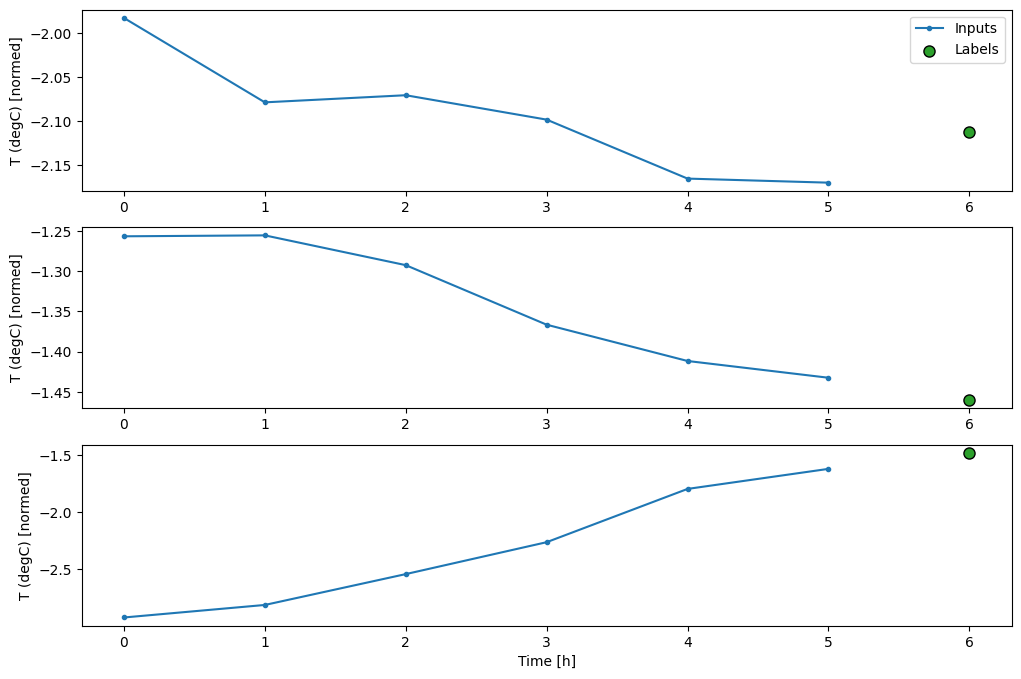

In [42]:
w2.example = example_inputs, example_labels
w2.plot()

Finally, we make tf dataset objects.  We do this by adding a make_dataset method to our WindowGenerator that converts the data frames to ds objects pairs (input_window, label_window).  

In [43]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The WindowGenerator object holds training, validation and test data.  We add properties
for accessing these objects using the made dataset method we just defined.

In [44]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

The WindowGenerator oejctive now allows us to access the tf.data.Dataset objects so we can easily iterate over the data.  The Dataset.element_spc property gives us information on the structure, data types, and shapes of the dataset elements.

In [11]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a Dataset yields concrete batches

In [45]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Input shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (bathc, time, features): {example_labels.shape}')

Input shape (batch, time, features): (32, 6, 19)
Labels shape (bathc, time, features): (32, 1, 1)


2025-03-17 10:52:15.340350: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


We are now going to build several forecasting models.
1) the simplest forecasting model predicts the temperature one hour into the future using the entire feature vector of inputs

In [46]:
single_step_window = WindowGenerator(
    input_width = 1, label_width = 1, shift = 1,
    label_columns=['T (degC)'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

We create the tf.data.Datasets from the training, validation, and test sets by iterating over batches of data.  

In [47]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


 Before buildiing a model, we need to have a performance baseline as a point of comparison.  

 This baselines predicts the temperature one hour into the future, given the current value of all features.  The current values include the current temperature.  So we consider a baseline model that simply returns the current prediction as the prediction.  This is reasonable if temperature changes slowly 

 

In [48]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

We now instantiate the baseline model and evaluate it 

Note we are creating a dictionary of val/test performance evaluations whose keyword is the type of model we are using.  So this will help us keep track of the performance of the other models we are going to consider.

In [49]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.0128 - mean_absolute_error: 0.0778


The WindowGenerator has a plot method.  We modify this function to generate windows of 24 hours of consecutive inputs and labels at a time.  The new wide_window variable doesn't change the way the model operates.  The model still makes predictions one hour into the future based on a single input time step.  Here time axis acts like the batch axies.  each prediction is made independently with now interaction between time steps.

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']


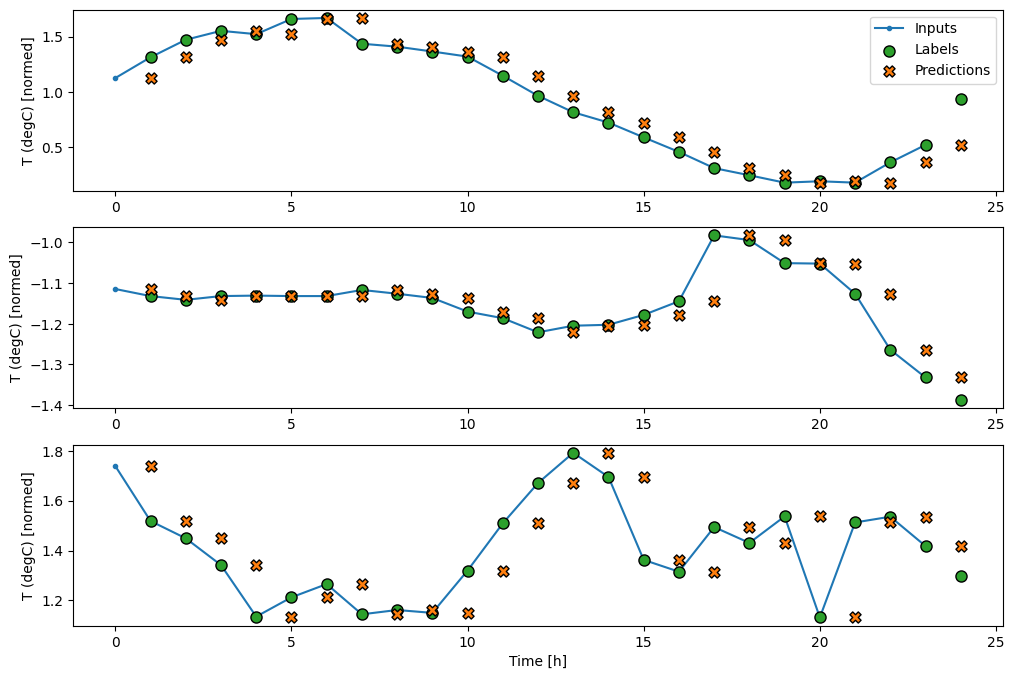

In [55]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

print(wide_window)

wide_window.plot(baseline)

The next simplest model is a lieanr model (ax+b).  We first define it is a sequential model with a single dense layer of one unit.  If no activation is specified, then the default is linear.  

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 1)
])

print('Input shape:', single_step_window.example[0].shape)
print('output shape:', linear(single_step_window.example[0]).shape)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Input shape: (32, 1, 19)
output shape: (32, 1, 1)


Since we will be training many different types of models, we package the training procedure into a function

In [56]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

We now train the "linear" model and evaluate its performance

In [64]:
history = compile_and_fit(linear, single_step_window)

linear.summary()

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5389 - mean_absolute_error: 0.4603 - val_loss: 0.0203 - val_mean_absolute_error: 0.1053
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0171 - mean_absolute_error: 0.0972 - val_loss: 0.0103 - val_mean_absolute_error: 0.0751
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step - loss: 0.0102 - mean_absolute_error: 0.0746 - val_loss: 0.0092 - val_mean_absolute_error: 0.0701
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0708 - val_loss: 0.0091 - val_mean_absolute_error: 0.0699
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0088 - val_mean_absolute_error: 0.0683
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089 - mean_absolute_error: 0.0691 - val_loss: 0.0088 - val_mean_absolute_error: 0.0676
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089 - mean_absolute

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (32, 1, 1)             │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62 (252.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42 (172.00 B)

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.0088 - mean_absolute_error: 0.0685


The linear model can also be called on batches of wide windows.  Used this way the model makes a set of independent predictions on conseuctive time steps.  The time axis acts like another batch axis.

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


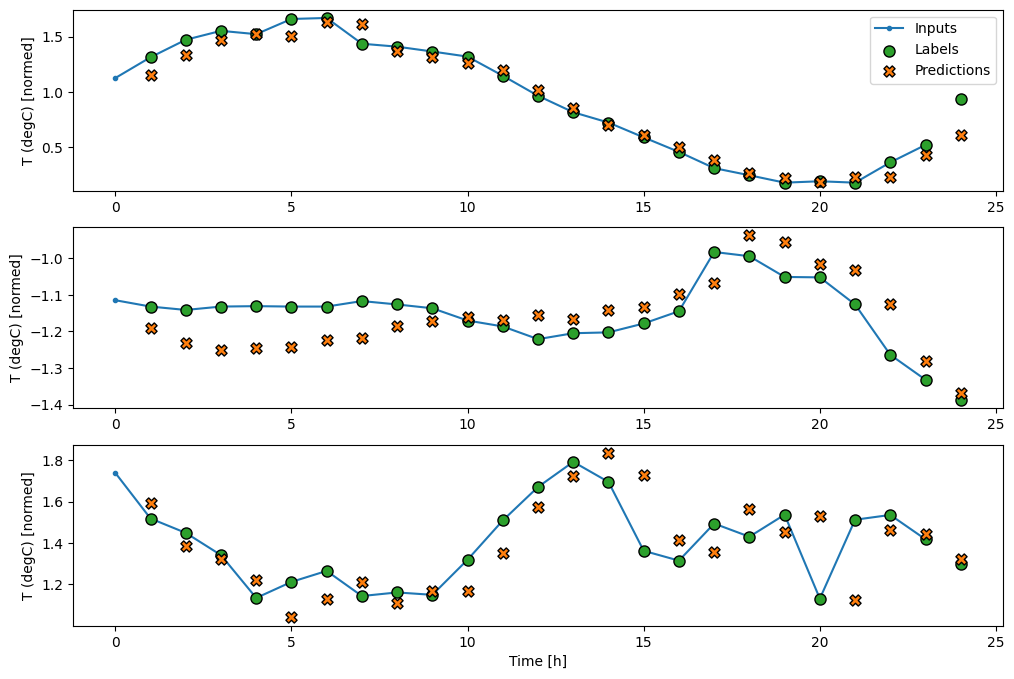

In [65]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

wide_window.plot(linear)


One advantage of the linear model is that its weights are easy to interpret.  They simply represent the sensitivity of the prediction to the paritcular input variable.  

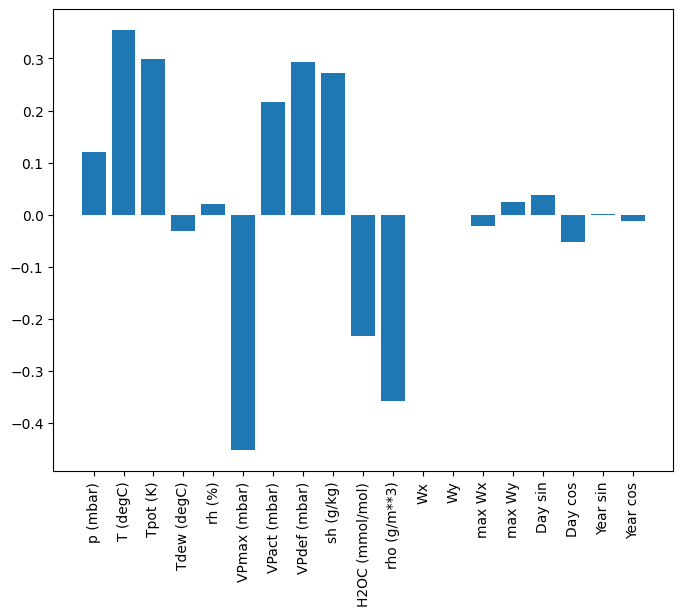

In [59]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Now lets consider a model that is dense.  It has two layers of 64 nodes with relu activation.  Note that the training of this model is very seasy now.  

In [66]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])


history = compile_and_fit(dense, single_step_window)

dense.summary()

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0405 - mean_absolute_error: 0.1120 - val_loss: 0.0077 - val_mean_absolute_error: 0.0634
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0645 - val_loss: 0.0074 - val_mean_absolute_error: 0.0612
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0620 - val_loss: 0.0071 - val_mean_absolute_error: 0.0606
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0609 - val_loss: 0.0067 - val_mean_absolute_error: 0.0576
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0597 - val_loss: 0.0068 - val_mean_absolute_error: 0.0585
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0070 - mean_absolute_error: 0.0595 - val_loss: 0.0066 - val_mean_absolute_error: 0.0568
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0068 - mean_absolute_err

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 1, 64)          │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,517 (64.52 KB)

 Trainable params: 5,505 (21.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,012 (43.02 KB)

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 0.0070 - mean_absolute_error: 0.0600


Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


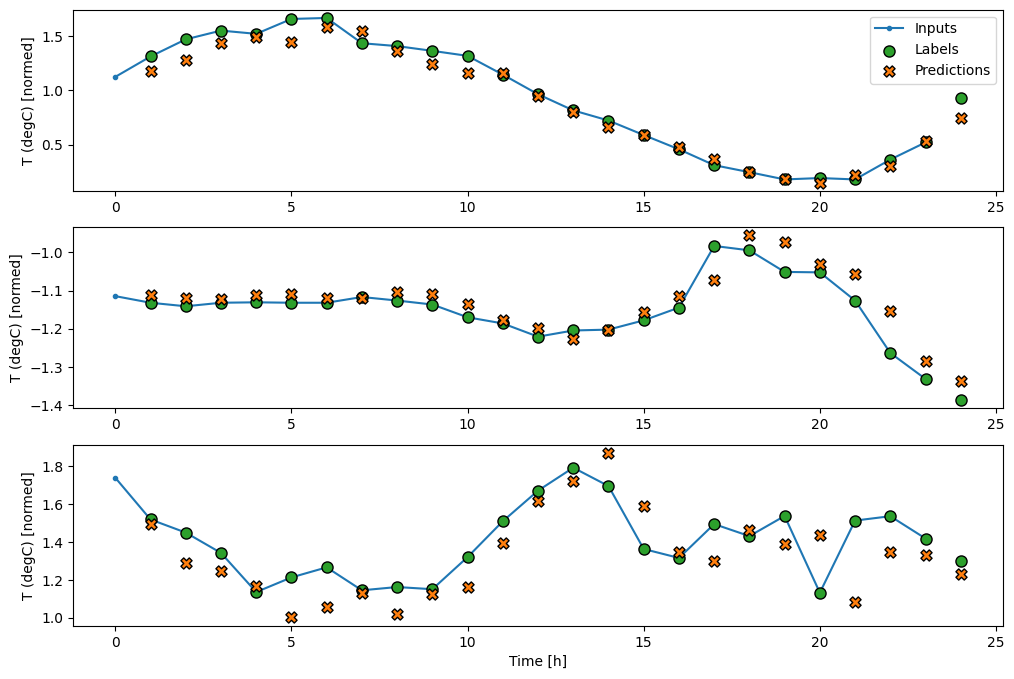

In [67]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

wide_window.plot(dense)

A single-time-step model may now work as well because it has no context for the current value of its inputs.  So we can address this by giving hte model access to mutiple time steps.  For instance, the inputs at t=0,1,2 woudl then be used to forecast 1 hour ahead at t=3.  

We start by creating a WindowGenerator that produces batches of three-hour inptus and one hour targets.  

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']


Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

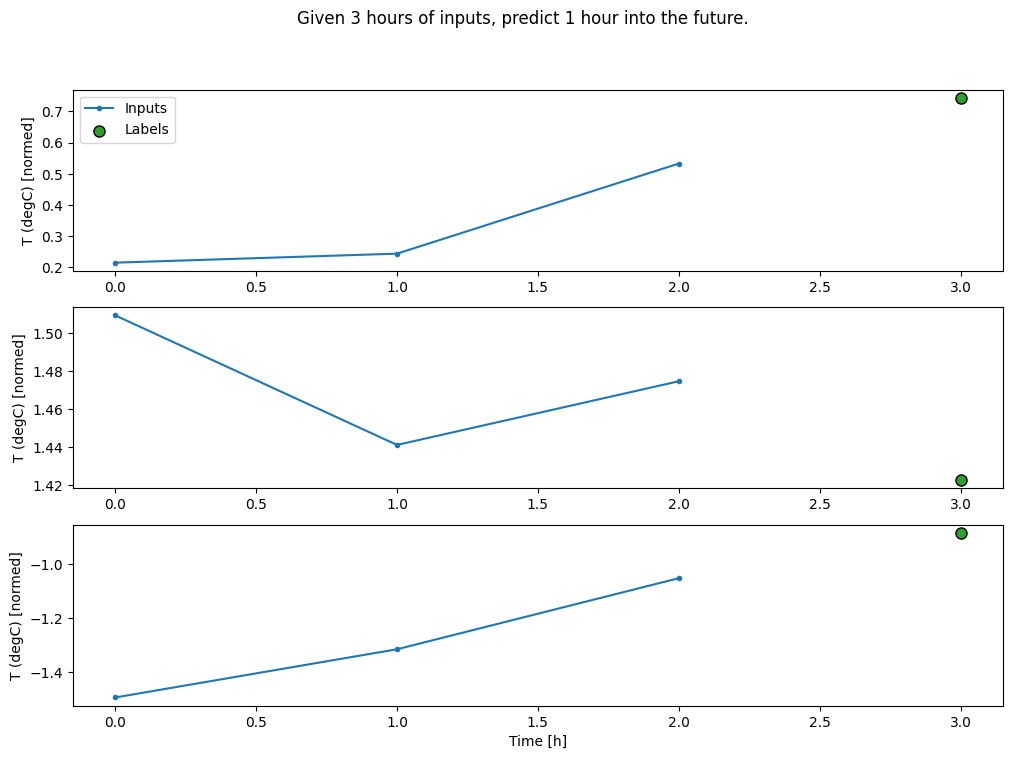

In [68]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

print(conv_window)

conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")



We train a dense model on the multiple-input-step window by ading a Flatten layer as the first layer of the model:

In [69]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


We now compile and fit and then evaluate the validation and test performance. 

In [70]:
history = compile_and_fit(multi_step_dense, conv_window)

multi_step_dense.summary()

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0071 - mean_absolute_error: 0.0595


We plot the predictions for our stack of three as shown below

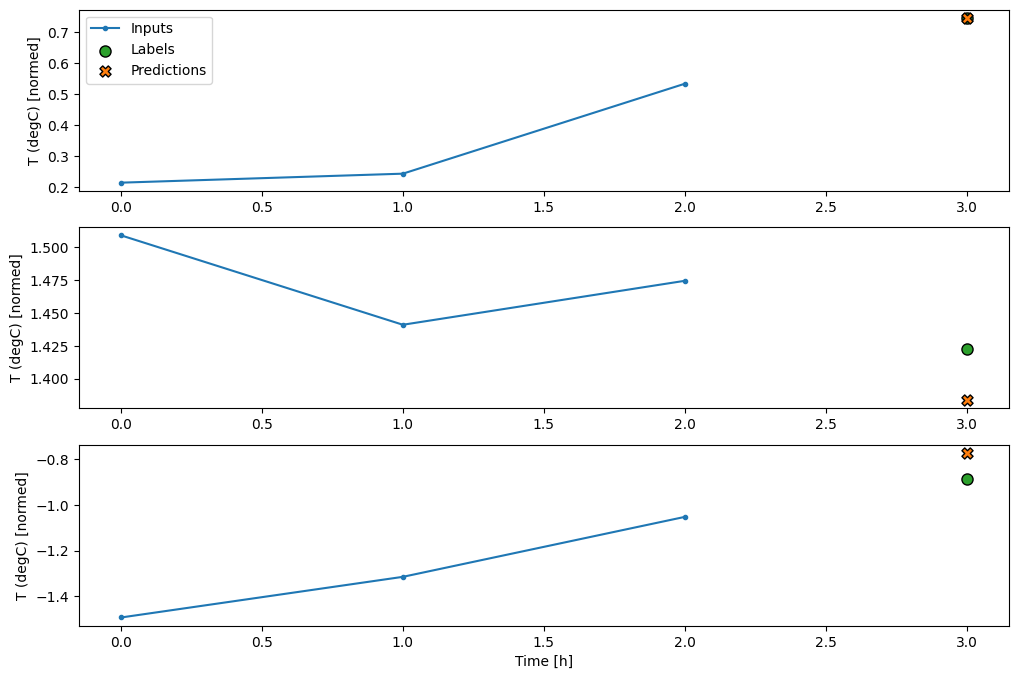

In [71]:
conv_window.plot(multi_step_dense)

We now introduce a convolutional model .  
1) we replace the flatten and dense layers by Conv1D
2) the reshape layer is no longer needed since convolution keeps the time axis in its output

In [72]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate 

In [ ]:
history = compile_and_fit(conv_model, conv_window)

conv_model.summary()

#IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.0065 - mean_absolute_error: 0.0578


The output is shorter than the input.  To amke training or plotting work, you need the labels and predictions to have the same length.  So build WindowGenerator to produce wide windows with a few extra timesteps so the label and prediction lengths match.

In [74]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [75]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


We can now plot the model's predictions on the wider window.  Note that 3 input timesteps before the first predcction.  These predictions are based on the 3 preceding timesteps, which are not there.

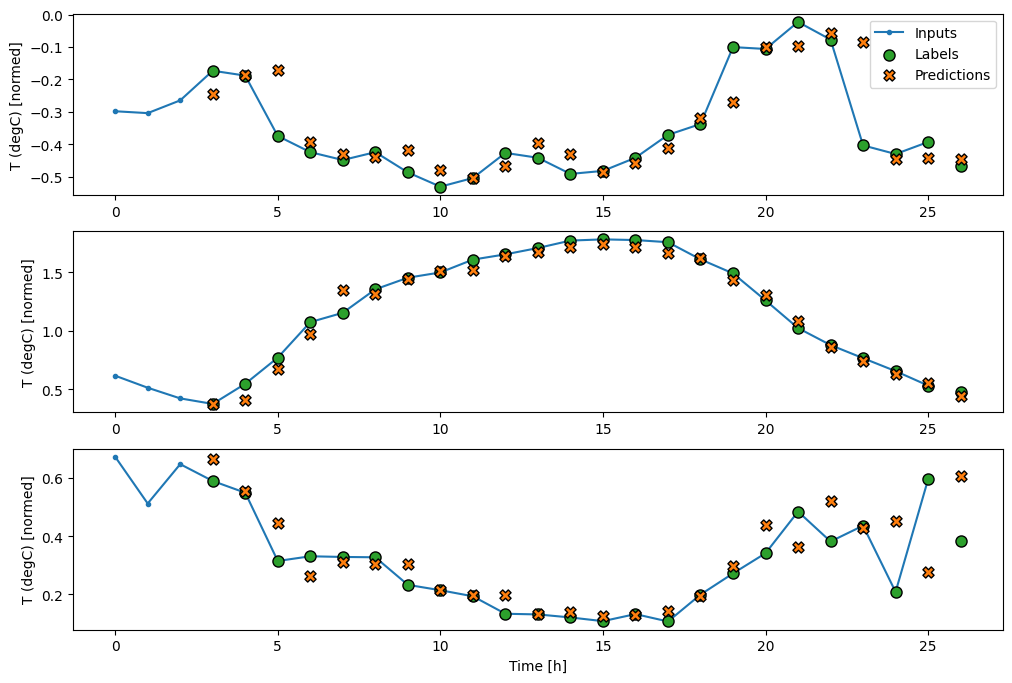

In [76]:
wide_conv_window.plot(conv_model)

A recurrent neural network is a type of neural network built for teime series analysis.  RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.  In this section we use an RNN layer called a Long Short-Term memory (LSTM) layer.  

An important arguments in all Keras RNN layers is the return_sequences argument.  If we set it to False, the layer only returns the output of the final time step.  Given, the model time to warm up its internal state before making a single prediction.   If True, the layer returns and output for each input.  This is useful when we stack RNN layers and for training a model on multiple time steps simultaneously.



In [77]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

we now compile, fit and evaluate the model's performance

In [81]:
history = compile_and_fit(lstm_model, wide_window)

lstm_model.summary()

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0049 - mean_absolute_error: 0.0486 - val_loss: 0.0059 - val_mean_absolute_error: 0.0530
Epoch 2/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0048 - mean_absolute_error: 0.0485 - val_loss: 0.0058 - val_mean_absolute_error: 0.0520
Epoch 3/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0048 - mean_absolute_error: 0.0483 - val_loss: 0.0058 - val_mean_absolute_error: 0.0526
Epoch 4/20
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0048 - mean_absolute_error: 0.0483 - val_loss: 0.0058 - val_mean_absolute_error: 0.0523


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 32)         │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 24, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,069 (78.40 KB)

 Trainable params: 6,689 (26.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,380 (52.27 KB)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0058 - mean_absolute_error: 0.0521


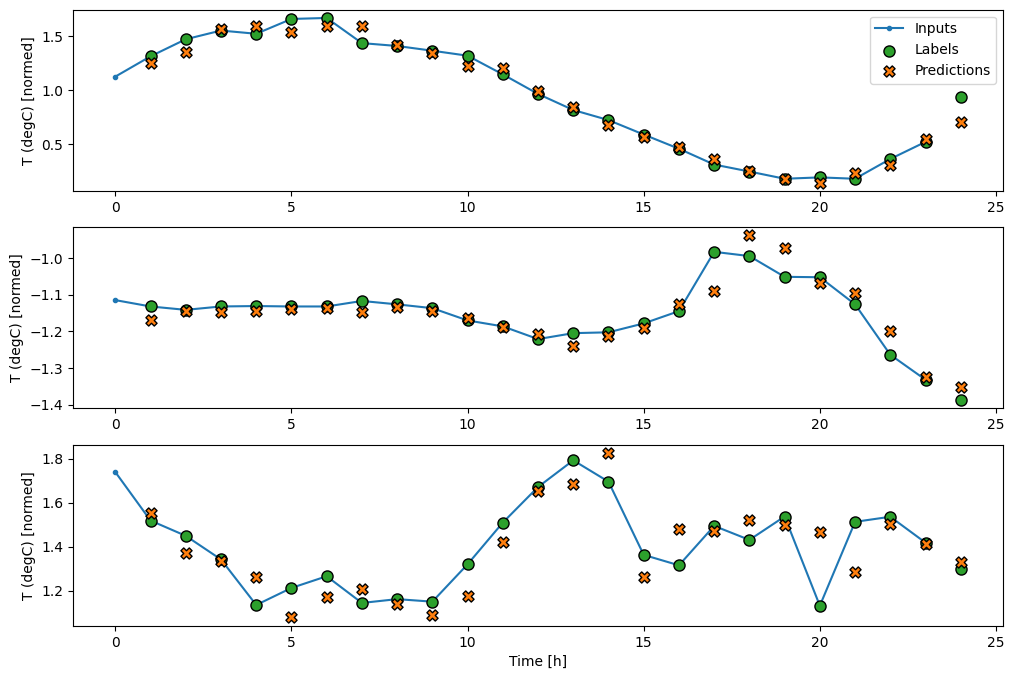

In [82]:
wide_window.plot(lstm_model)

Note that we saved the performance values is a dictionary.  So we have all of our past outcomes that can be compared against each other


Baseline                : 0.0852
Linear                  : 0.0673
Dense                   : 0.0622
Multi step dense        : 0.0641
Conv                    : 0.0577
LSTM                    : 0.0527


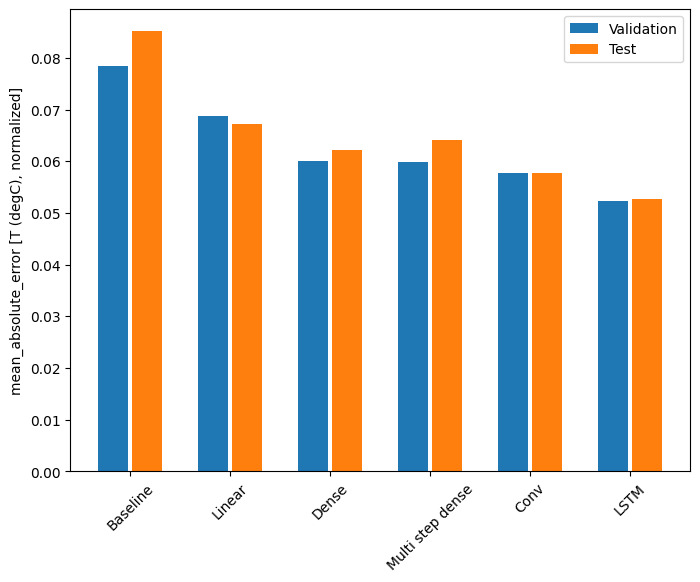

In [83]:


x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:24s}: {value[metric_name]:0.4f}')